In [1]:
import re

pattern_1 = r"\[.+\] \(.+\): INFO Train: \[[0-9\/]+\]\[[0-9\/]+\]\tETA: [0-9:]+\tlr [0-9\.]+\tBatch Time: [0-9\.]+ \([0-9\.]+\)\tLoss: [0-9\.]+ \(([0-9\.]+)\)\tGrad Norm: .+ \(.+\)\tMemory: [0-9]+MB\n\[.+\] \(.+\): INFO EPOCH ([0-9]+) training takes: [0-9:]+"
pattern_2 = r"\[.+\] \(.+\): INFO Test: \[.+\]\tBatch Time: [0-9\.]+ \([0-9\.]+\)\tLoss: [0-9\.]+ \(([0-9\.]+)\)\tAcc@1: [0-9\.]+ \([0-9\.]+\)\tAcc@5: [0-9\.]+ \([0-9\.]+\)\tAccMany: [0-9\.]+ \([0-9\.]+\)\tAccMid: [0-9\.]+ \([0-9\.]+\)\tAccLow: [0-9\.]+ \([0-9\.]+\)\tMemory: [0-9]+MB\n\[.+\] \(.+\): INFO  -=-= Acc@1 ([0-9\.]+) Acc@5 ([0-9\.]+)[ ]+AccMany ([0-9\.]+) AccMid ([0-9\.]+) AccLow ([0-9\.]+)"
log_path = r"E:\Rivan\Tugas Akhir\MetaFormerBSL\output\MetaFG_meta_0\MetaFormer_0-iNat2018-Balanced_Softmax_Loss\log_rank_0.txt"

with open(log_path, 'r') as f:
    text = f.read()
    train_loss_match = re.findall(pattern_1, text)
    test_results_match = re.findall(pattern_2, text)
test_results_match = test_results_match[3:] # error logs on first 3 test results

print(train_loss_match, len(train_loss_match))
print(test_results_match, len(test_results_match))

[('8.0960', '1'), ('6.6662', '2'), ('5.7754', '3'), ('5.2769', '4'), ('4.9104', '5'), ('4.6516', '6'), ('4.4763', '7'), ('4.3508', '8'), ('4.2886', '9'), ('4.2250', '10'), ('4.1808', '11'), ('4.1198', '12'), ('4.0765', '13'), ('4.0377', '14'), ('3.9948', '15'), ('4.0096', '16'), ('3.9613', '17'), ('3.9516', '18'), ('3.9254', '19'), ('3.9099', '20'), ('3.8852', '21'), ('3.8784', '22'), ('3.8544', '23'), ('3.8516', '24'), ('3.8409', '25'), ('3.7999', '26'), ('3.8239', '27'), ('3.8074', '28'), ('3.7803', '29'), ('3.7743', '30'), ('3.7669', '31'), ('3.7456', '32'), ('3.7338', '33'), ('3.7388', '34'), ('3.7277', '35'), ('3.7194', '36'), ('3.7174', '37'), ('3.6998', '38'), ('3.6889', '39'), ('3.6898', '40'), ('3.6866', '41'), ('3.6768', '42'), ('3.6652', '43'), ('3.6528', '44'), ('3.6494', '45'), ('3.6455', '46'), ('3.6452', '47'), ('3.6444', '48'), ('3.6165', '49'), ('3.6029', '50'), ('3.5899', '51'), ('3.5975', '52'), ('3.5976', '53'), ('3.5733', '54'), ('3.5590', '55'), ('3.5661', '56'), 

In [2]:
epochs = 150

train_loss = list()

normal_test_loss = list()
normal_test_acc1 = list()
normal_test_acc5 = list()
normal_test_accmany = list()
normal_test_accmid = list()
normal_test_acclow = list()

masked_test_loss = list()
masked_test_acc1 = list()
masked_test_acc5 = list()
masked_test_accmany = list()
masked_test_accmid = list()
masked_test_acclow = list()

for epoch in range(epochs):
    train_loss.append(train_loss_match[epoch][0]) # loss at index 0

    normal_test_index = 2 * epoch
    masked_test_index = 2 * epoch + 1

    normal_test_loss.append(test_results_match[normal_test_index][0])
    normal_test_acc1.append(test_results_match[normal_test_index][1])
    normal_test_acc5.append(test_results_match[normal_test_index][2])
    normal_test_accmany.append(test_results_match[normal_test_index][3])
    normal_test_accmid.append(test_results_match[normal_test_index][4])
    normal_test_acclow.append(test_results_match[normal_test_index][5])

    masked_test_loss.append(test_results_match[masked_test_index][0])
    masked_test_acc1.append(test_results_match[masked_test_index][1])
    masked_test_acc5.append(test_results_match[masked_test_index][2])
    masked_test_accmany.append(test_results_match[masked_test_index][3])
    masked_test_accmid.append(test_results_match[masked_test_index][4])
    masked_test_acclow.append(test_results_match[masked_test_index][5])

print(masked_test_loss)



['8.5644', '6.5703', '4.9892', '3.7014', '2.7781', '2.2499', '1.7919', '1.5921', '1.4955', '1.5101', '1.3829', '1.3258', '1.2703', '1.2422', '1.3022', '1.2540', '1.1365', '1.2024', '1.2240', '1.1764', '1.1649', '1.1938', '1.1557', '1.1563', '1.1748', '1.0886', '1.1533', '1.1354', '1.1366', '1.1546', '1.1906', '1.2146', '1.1680', '1.1362', '1.1430', '1.2729', '1.1324', '1.2411', '1.1578', '1.1029', '1.2305', '1.1665', '1.0969', '1.1469', '1.2333', '1.1772', '1.2954', '1.1711', '1.1519', '1.1619', '1.1215', '1.1178', '1.1322', '1.1595', '1.1166', '1.1907', '1.1940', '1.0986', '1.1765', '1.1886', '1.1592', '1.2112', '1.1363', '1.1738', '1.1201', '1.1529', '1.1744', '1.1787', '1.1927', '1.1237', '1.1753', '1.1152', '1.1398', '1.1950', '1.1752', '1.1712', '1.1135', '1.2332', '1.2113', '1.2371', '1.2199', '1.1456', '1.1179', '1.1957', '1.2267', '1.2714', '1.1734', '1.2471', '1.1843', '1.2196', '1.1402', '1.1942', '1.1343', '1.1326', '1.2752', '1.1517', '1.1313', '1.1814', '1.1239', '1.1001',

In [3]:
print(train_loss)
print(min(train_loss), train_loss.index(min(train_loss)))


print(normal_test_loss)
print(min(normal_test_loss), normal_test_loss.index(min(normal_test_loss)))

print(masked_test_loss)
print(min(masked_test_loss), masked_test_loss.index(min(masked_test_loss)))

print(normal_test_acc1)
print(max(normal_test_acc1), normal_test_acc1.index(max(normal_test_acc1)))

print(masked_test_acc1)
print(max(masked_test_acc1), masked_test_acc1.index(max(masked_test_acc1)))

['8.0960', '6.6662', '5.7754', '5.2769', '4.9104', '4.6516', '4.4763', '4.3508', '4.2886', '4.2250', '4.1808', '4.1198', '4.0765', '4.0377', '3.9948', '4.0096', '3.9613', '3.9516', '3.9254', '3.9099', '3.8852', '3.8784', '3.8544', '3.8516', '3.8409', '3.7999', '3.8239', '3.8074', '3.7803', '3.7743', '3.7669', '3.7456', '3.7338', '3.7388', '3.7277', '3.7194', '3.7174', '3.6998', '3.6889', '3.6898', '3.6866', '3.6768', '3.6652', '3.6528', '3.6494', '3.6455', '3.6452', '3.6444', '3.6165', '3.6029', '3.5899', '3.5975', '3.5976', '3.5733', '3.5590', '3.5661', '3.5574', '3.5443', '3.5444', '3.5387', '3.5199', '3.5301', '3.5090', '3.5111', '3.5100', '3.5022', '3.4975', '3.4842', '3.4781', '3.4851', '3.4905', '3.4745', '3.4705', '3.4639', '3.4413', '3.4242', '3.4306', '3.4242', '3.4034', '3.4083', '3.3938', '3.4083', '3.4071', '3.3990', '3.3930', '3.3904', '3.3662', '3.3828', '3.3777', '3.3510', '3.3444', '3.3576', '3.3551', '3.3494', '3.3199', '3.3377', '3.3246', '3.3313', '3.3106', '3.2866',

In [4]:
!pip install matplotlib

In [5]:
import numpy as np

epochs_range = np.array(range(1, 150 + 1))

train_loss = np.array(train_loss).astype(float)
normal_test_loss = np.array(normal_test_loss).astype(float)
masked_test_loss = np.array(masked_test_loss).astype(float)
normal_test_acc1 = np.array(normal_test_acc1).astype(float)
masked_test_acc1 = np.array(masked_test_acc1).astype(float)

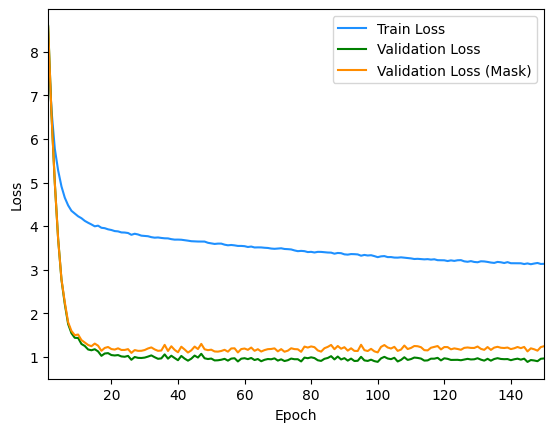

In [6]:
from matplotlib import pyplot as plt

plt.plot(epochs_range, train_loss, label="Train Loss", color='dodgerblue')
plt.plot(epochs_range, normal_test_loss, label="Validation Loss", color='green')
plt.plot(epochs_range, masked_test_loss, label="Validation Loss (Mask)", color='darkorange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(1, 150)
plt.legend()

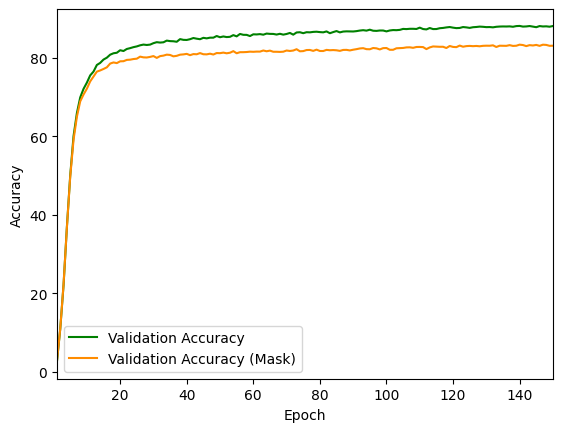

In [7]:
from matplotlib import pyplot as plt

plt.plot(epochs_range, normal_test_acc1, label="Validation Accuracy", color='green')
plt.plot(epochs_range, masked_test_acc1, label="Validation Accuracy (Mask)", color='darkorange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim(1, 150)
plt.legend()

In [8]:
normal_test_acc1_bsl = normal_test_acc1
masked_test_acc1_bsl = masked_test_acc1

In [9]:
log_path_2 = r"E:\Rivan\Tugas Akhir\MetaFormerBSL\output\MetaFG_meta_0\MetaFormer_0-iNat2018-Softmax_Loss\log_rank_0.txt"

with open(log_path_2, 'r') as f:
    text = f.read()
    train_loss_match = re.findall(pattern_1, text)
    test_results_match = re.findall(pattern_2, text)

print(train_loss_match, len(train_loss_match))
print(test_results_match, len(test_results_match))

[('8.5989', '1'), ('6.8996', '2'), ('5.7839', '3'), ('5.2398', '4'), ('4.8813', '5'), ('4.6416', '6'), ('4.4709', '7'), ('4.3715', '8'), ('4.2967', '9'), ('4.2419', '10'), ('4.1807', '11'), ('4.1272', '12'), ('4.0755', '13'), ('4.0282', '14'), ('4.0454', '15'), ('3.9924', '16'), ('3.9810', '17'), ('3.9541', '18'), ('3.9331', '19'), ('3.9091', '20'), ('3.8990', '21'), ('3.8727', '22'), ('3.8660', '23'), ('3.8598', '24'), ('3.8213', '25'), ('3.8369', '26'), ('3.8224', '27'), ('3.7929', '28'), ('3.7882', '29'), ('3.7806', '30'), ('3.7569', '31'), ('3.7471', '32'), ('3.7532', '33'), ('3.7398', '34'), ('3.7279', '35'), ('3.7242', '36'), ('3.7113', '37'), ('3.7019', '38'), ('3.6991', '39'), ('3.7008', '40'), ('3.6842', '41'), ('3.6756', '42'), ('3.6575', '43'), ('3.6546', '44'), ('3.6535', '45'), ('3.6524', '46'), ('3.6526', '47'), ('3.6248', '48'), ('3.6108', '49'), ('3.6039', '50'), ('3.6068', '51'), ('3.6069', '52'), ('3.5879', '53'), ('3.5709', '54'), ('3.5713', '55'), ('3.5674', '56'), 

In [10]:
epochs = 57

train_loss = list()

normal_test_loss = list()
normal_test_acc1 = list()
normal_test_acc5 = list()
normal_test_accmany = list()
normal_test_accmid = list()
normal_test_acclow = list()

masked_test_loss = list()
masked_test_acc1 = list()
masked_test_acc5 = list()
masked_test_accmany = list()
masked_test_accmid = list()
masked_test_acclow = list()

for epoch in range(epochs):
    train_loss.append(train_loss_match[epoch][0]) # loss at index 0

    normal_test_index = 2 * epoch
    masked_test_index = 2 * epoch + 1

    normal_test_loss.append(test_results_match[normal_test_index][0])
    normal_test_acc1.append(test_results_match[normal_test_index][1])
    normal_test_acc5.append(test_results_match[normal_test_index][2])
    normal_test_accmany.append(test_results_match[normal_test_index][3])
    normal_test_accmid.append(test_results_match[normal_test_index][4])
    normal_test_acclow.append(test_results_match[normal_test_index][5])

    masked_test_loss.append(test_results_match[masked_test_index][0])
    masked_test_acc1.append(test_results_match[masked_test_index][1])
    masked_test_acc5.append(test_results_match[masked_test_index][2])
    masked_test_accmany.append(test_results_match[masked_test_index][3])
    masked_test_accmid.append(test_results_match[masked_test_index][4])
    masked_test_acclow.append(test_results_match[masked_test_index][5])

print(masked_test_loss)



['9.1957', '6.8302', '5.1260', '3.8004', '2.8972', '2.3419', '1.9982', '1.8700', '1.7671', '1.5727', '1.4880', '1.4814', '1.4642', '1.4171', '1.3784', '1.2133', '1.2862', '1.3232', '1.2471', '1.2204', '1.2526', '1.2513', '1.2943', '1.2848', '1.1777', '1.2553', '1.2047', '1.2470', '1.1662', '1.2855', '1.3779', '1.3043', '1.2519', '1.1868', '1.3923', '1.1876', '1.3127', '1.2271', '1.1782', '1.3190', '1.2312', '1.1488', '1.2341', '1.3454', '1.3178', '1.3187', '1.3052', '1.2118', '1.2082', '1.2259', '1.2341', '1.2064', '1.2863', '1.2213', '1.3556', '1.3026', '1.1954']


In [11]:
print(train_loss)
print(min(train_loss), train_loss.index(min(train_loss)))


print(normal_test_loss)
print(min(normal_test_loss), normal_test_loss.index(min(normal_test_loss)))

print(masked_test_loss)
print(min(masked_test_loss), masked_test_loss.index(min(masked_test_loss)))

print(normal_test_acc1)
print(max(normal_test_acc1), normal_test_acc1.index(max(normal_test_acc1)))

print(masked_test_acc1)
print(max(masked_test_acc1), masked_test_acc1.index(max(masked_test_acc1)))

['8.5989', '6.8996', '5.7839', '5.2398', '4.8813', '4.6416', '4.4709', '4.3715', '4.2967', '4.2419', '4.1807', '4.1272', '4.0755', '4.0282', '4.0454', '3.9924', '3.9810', '3.9541', '3.9331', '3.9091', '3.8990', '3.8727', '3.8660', '3.8598', '3.8213', '3.8369', '3.8224', '3.7929', '3.7882', '3.7806', '3.7569', '3.7471', '3.7532', '3.7398', '3.7279', '3.7242', '3.7113', '3.7019', '3.6991', '3.7008', '3.6842', '3.6756', '3.6575', '3.6546', '3.6535', '3.6524', '3.6526', '3.6248', '3.6108', '3.6039', '3.6068', '3.6069', '3.5879', '3.5709', '3.5713', '3.5674', '3.5543']
3.5543 56
['9.1033', '6.8307', '5.1089', '3.7735', '2.8594', '2.2847', '1.9206', '1.7718', '1.6679', '1.4544', '1.3743', '1.3635', '1.3319', '1.2877', '1.2206', '1.0866', '1.1323', '1.1639', '1.0995', '1.0651', '1.0953', '1.0845', '1.1031', '1.0966', '1.0179', '1.0762', '1.0198', '1.0515', '0.9863', '1.0658', '1.1396', '1.0897', '1.0305', '0.9880', '1.1483', '0.9836', '1.0974', '1.0079', '0.9593', '1.0875', '1.0019', '0.9335'

In [12]:
import numpy as np

epochs_range = np.array(range(1, 57 + 1))

train_loss = np.array(train_loss).astype(float)
normal_test_loss = np.array(normal_test_loss).astype(float)
masked_test_loss = np.array(masked_test_loss).astype(float)
normal_test_acc1 = np.array(normal_test_acc1).astype(float)
masked_test_acc1 = np.array(masked_test_acc1).astype(float)

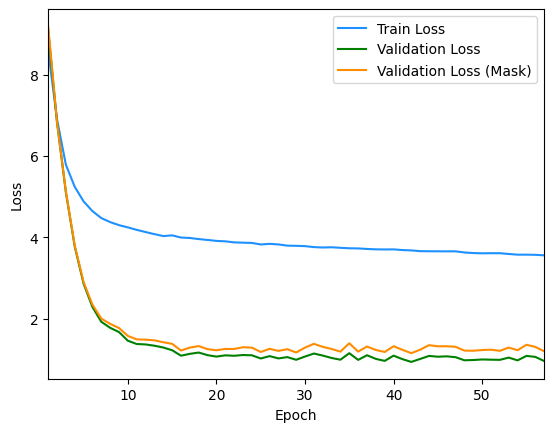

In [13]:
from matplotlib import pyplot as plt

plt.plot(epochs_range, train_loss, label="Train Loss", color='dodgerblue')
plt.plot(epochs_range, normal_test_loss, label="Validation Loss", color='green')
plt.plot(epochs_range, masked_test_loss, label="Validation Loss (Mask)", color='darkorange')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xlim(1, 57)
plt.legend()

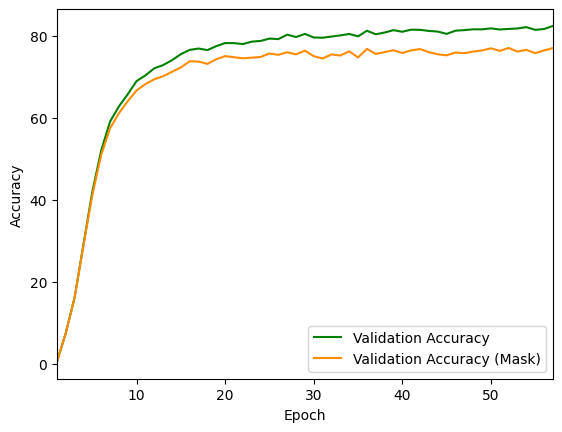

In [14]:
from matplotlib import pyplot as plt

plt.plot(epochs_range, normal_test_acc1, label="Validation Accuracy", color='green')
plt.plot(epochs_range, masked_test_acc1, label="Validation Accuracy (Mask)", color='darkorange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim(1, 57)
plt.legend()

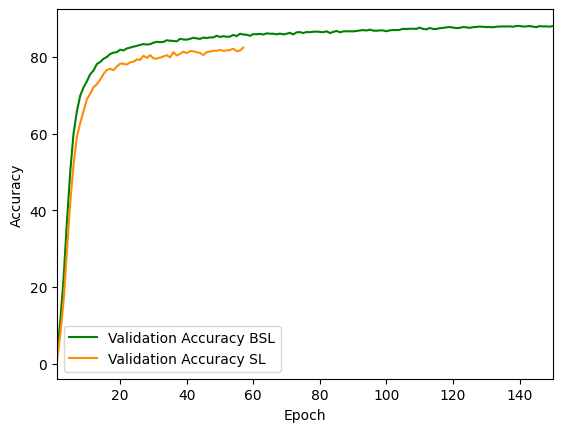

In [15]:
from matplotlib import pyplot as plt

plt.plot(np.array(range(1, 150 + 1)), normal_test_acc1_bsl, label="Validation Accuracy BSL", color='green')
plt.plot(np.array(range(1, 57 + 1)), normal_test_acc1, label="Validation Accuracy SL", color='darkorange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim(1, 150)
plt.legend()

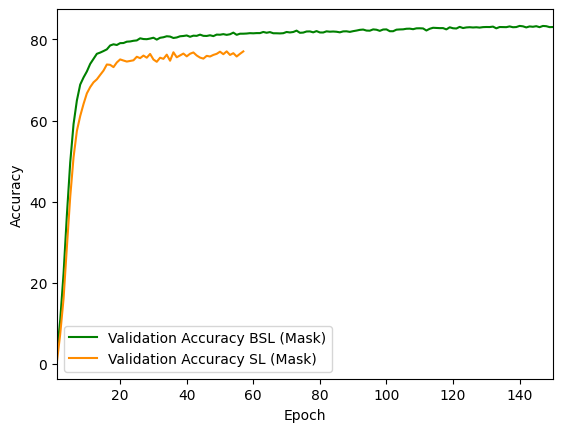

In [16]:
from matplotlib import pyplot as plt

plt.plot(np.array(range(1, 150 + 1)), masked_test_acc1_bsl, label="Validation Accuracy BSL (Mask)", color='green')
plt.plot(np.array(range(1, 57 + 1)), masked_test_acc1, label="Validation Accuracy SL (Mask)", color='darkorange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.xlim(1, 150)
plt.legend()